In [1]:
# to enable auto complete
%config Completer.use_jedi = False

In [2]:
import os
import time
import random
import json
import glob
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
%matplotlib inline

In [3]:
with open('bbox-annotations.json', 'r') as f:
    annotations = json.load(f)

## Looking into the data

In [4]:
len(annotations['images']) 

2239

In [5]:
annotations['images'][0]

{'file_name': 'image_000000001.jpg',
 'width': 1024,
 'height': 768,
 'id': 0,
 'license': 1}

In [6]:
annotations['categories']

[{'id': 1, 'name': 'person', 'supercategory': 'none'},
 {'id': 2, 'name': 'car', 'supercategory': 'none'}]

In [7]:
images_annot = pd.DataFrame(annotations['images'])

In [8]:
annot = pd.DataFrame(annotations['annotations'])

In [9]:
annot.shape

(16772, 8)

In [10]:
# NOTE: bbox is in (left, top, width, height) format
annot.head(10)

category_id  image_id segmentation  iscrowd                  bbox  \
0            1         0           []        0  [846, 145, 146, 477]   
1            1         0           []        0  [848, 216, 175, 551]   
2            2         0           []        0     [74, 159, 75, 81]   
3            2         0           []        0  [153, 124, 658, 643]   
4            1         1           []        0    [488, 281, 28, 71]   
5            2         1           []        0    [26, 283, 145, 75]   
6            2         1           []        0   [592, 287, 121, 99]   
7            1         2           []        0       [8, 0, 80, 609]   
8            1         2           []        0    [57, 32, 151, 256]   
9            1         2           []        0    [167, 0, 289, 648]   

       area  id  license  
0  0.088554   0        2  
1  0.122611   1        2  
2  0.007725   2        2  
3  0.537992   3        2  
4  0.003370   4        2  
5  0.018438   5        2  
6  0.020309   6        2  
7  0.069661   7        2  
8  0.055271   8        2  
9  0.267764   9        2

In [11]:
images_annot.head(10)

file_name  width  height  id  license
0  image_000000001.jpg   1024     768   0        1
1  image_000000002.jpg   1024     576   1        1
2  image_000000003.jpg   1024     683   2        1
3  image_000000004.jpg   1024     675   3        1
4  image_000000005.jpg   1024     926   4        1
5  image_000000006.jpg   1024     683   5        1
6  image_000000007.jpg   1024     576   6        1
7  image_000000008.jpg   1024     768   7        1
8  image_000000009.jpg   1024     694   8        1
9  image_000000010.jpg   1024     683   9        1

## Sanity check

In [12]:
all_images = set([each.split('/')[-1] for each in glob.glob('images/*jpg')])

In [13]:
len(all_images)

2239

In [14]:
all_filenames = set([each['file_name'] for each in annotations['images']]) 

In [15]:
all_images - all_filenames, all_filenames - all_images

(set(), set())

##### Hence, annotations matches with actual images

## Visulalising them

In [16]:
color_mapping = {1:[0,0,255], 2:[255,0,0]}

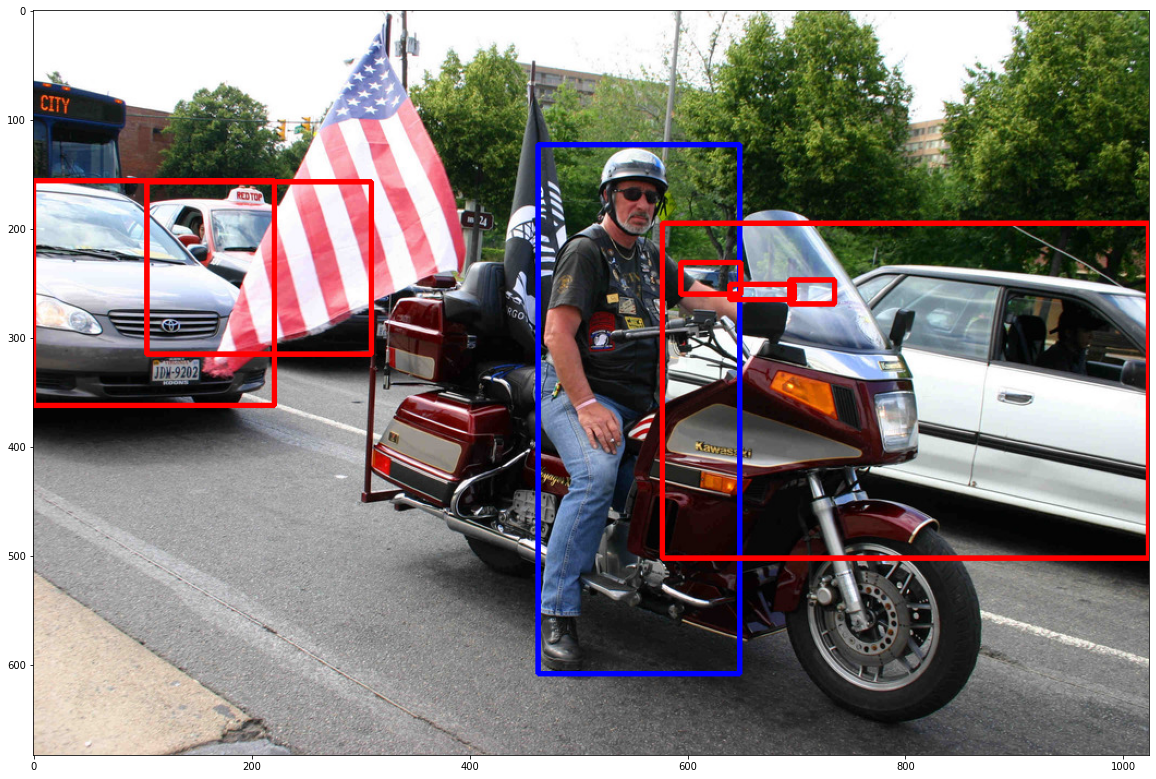

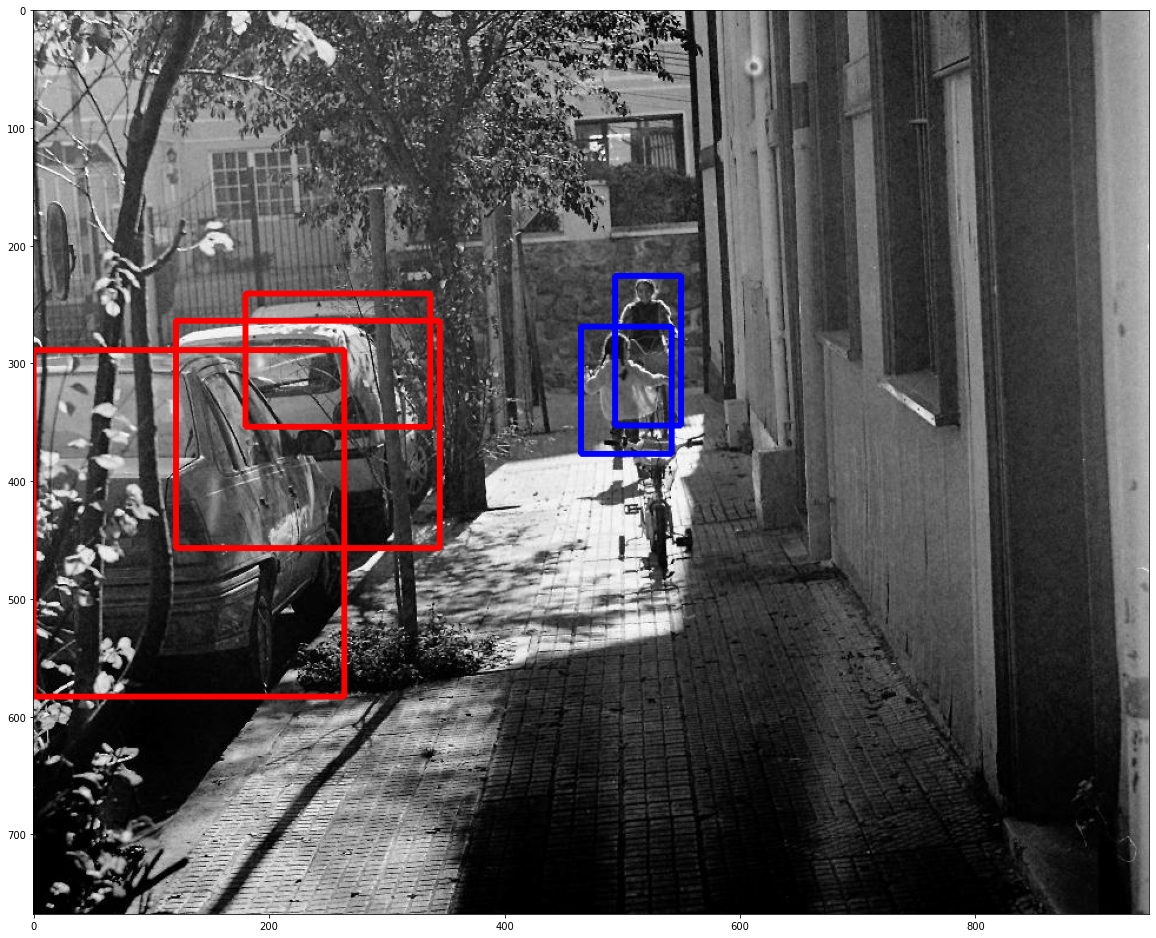

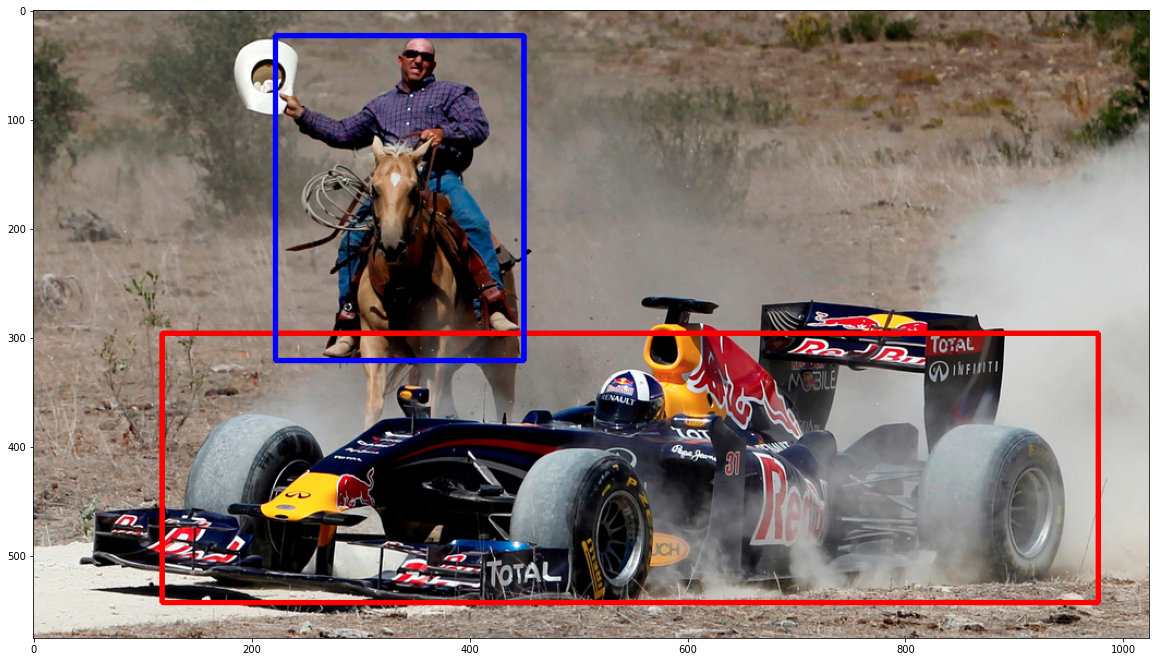

In [17]:


for idx in  [100,200,300]:

    img_path, img_id = annotations['images'][idx]['file_name'] , annotations['images'][idx]['id']
    img_path = os.path.join('images', img_path)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for index, row in annot[annot['image_id']==img_id].iterrows():
        pt1 = row['bbox'][:2]
        pt2 = np.sum([row['bbox'][:2], row['bbox'][2:]], axis=0)

        cv2.rectangle(img, tuple(pt1), tuple(pt2), tuple(color_mapping[row['category_id']]), 3)

    plt.figure(figsize=(20,20))
    plt.imshow(img)

## Analysis

- As can be seen in various images, objects are sometimes very small that human eyes struggle to see it. Hence, I have used a larger resolution of images for training, i.e. 608,608 (due to lack of resources, kept it optimal)

- There are various images with Occlusion that only a small part of object is visible. That's why I preferred Yolo v4 as it has performs some interesting data augmentation like CutMix during training to deal with such things.

- These are real world objects so flip augmentation will be useful here unlike mnist dataset

In [18]:
annot.groupby('image_id')['category_id'].apply(lambda x:len(np.unique(x))).value_counts()

2    2239
Name: category_id, dtype: int64

#### All images have both the classes present, i.e. no negative samples and that's a downside for yolo as its precision increases with the number of negative samples.

In [19]:
annot['category_id'].value_counts()

1    10800
2     5972
Name: category_id, dtype: int64

#### Categories are also somewhat imbalanced

In [20]:
np.unique(annot['iscrowd'])

array([0])

#### iscrowd is irrelevant as it is same all over the dataset

In [21]:
sum(annot['area'] < 0.01) / annot.shape[0]

0.4887908418793227

#### ~ 50 % of annotations are of less than 1% area but these images are of good resolution so it can be dealt with.

## Preparing text files

Converting the data from the annoatations json provided to the required training format.

* Need to make a .txt file with same prefix along side every corresponding image depicting annotations like:
    category x_center y_center w_bbox h_bbox
    * Note: Last 4 things should also be normalised as per image height and width.

* Now, create 2 files train.txt and test.txt containing absolute or relative path of corresponding images



Other steps:
* Create obj.data and obj.names files
* change yolov4-custom.cfg accordingly
* download model weights file

In [ ]:
for img_row in annotations['images']:
    H, W = img_row['height'], img_row['width']
    text_file_path = os.path.join('images', '.'.join(img_row['file_name'].split('.')[:-1]) + '.txt')
    with open(text_file_path, 'w') as f:
        for index, row in annot[annot['image_id']==img_row['id']].iterrows():
            bbox = row[4]
            x_center = min(int(bbox[0] + (bbox[2] / 2)), W)
            y_center = min(int(bbox[1] + (bbox[3] / 2)), H)
            f.write(f"{row[0]-1} {x_center/W} {y_center/H} {bbox[2]/W} {bbox[3]/H}\n")

## splitting the data

In [ ]:
all_images = glob.glob('images/*jpg')

In [ ]:
train_size = 0.8
split = int(len(all_images)*train_size)

random.shuffle(all_images)
all_images =["../"+ img for img in all_images]

with open('train.txt', 'w') as f:
    f.write('\n'.join(all_images[:split]))

with open('test.txt', 'w') as f:
    f.write('\n'.join(all_images[split:]))

## Training

In [ ]:
# done on colab, please look into attached training notebook

In [22]:
with open('darknet/data/train.txt', 'r') as f:
    train_imgs = f.readlines()
    train_imgs = [each.strip().split('/')[-1] for each in train_imgs]
    
with open('darknet/data/test.txt', 'r') as f:
    test_imgs = f.readlines()
    test_imgs = [each.strip().split('/')[-1] for each in test_imgs]

## Inference

In [87]:
from yolo import yolo_load, yolo_detect, image_yolo_detect

yolov4 = yolo_load(model_name="yolov4-custom")

color_mapping = {1:[0,0,255], 2:[255,0,0]}
cat_color_mapping = {'person':[0,0,255], 'car':[255,0,0]}

In [88]:
# selecting image
demo_path = test_imgs[89]

img_id = images_annot[images_annot['file_name']==demo_path]['id'].iloc[0]
img_path = os.path.join( 'images', demo_path)

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
actual = img.copy()
predicted = img.copy()

In [89]:
## plotting bbox on actual
for index, row in annot[annot['image_id']==img_id].iterrows():
    pt1 = row['bbox'][:2]
    pt2 = np.sum([row['bbox'][:2], row['bbox'][2:]], axis=0)
    cv2.rectangle(actual, tuple(pt1), tuple(pt2), tuple(color_mapping[row['category_id']]), 3)

In [90]:
img_path

'images/image_000002106.jpg'

In [91]:
## predictions
start = time.time()
detections = yolo_detect(yolov4, input_filepath=[img_path], 
                               confidence_threshold=0.3, 
                               yolo_width=608, 
                               yolo_height=608, 
                               save_output=False,
                                nms_threshold= 0.3)
print('inference time: ', time.time()-start)

inference time:  1.2682993412017822


In [92]:
## plotting bbox on predicted
for cat, conf, bbox in detections[0]:
    pt1 = bbox[:2]
    pt2 = np.sum([bbox[:2], bbox[2:]], axis=0)
    cv2.rectangle(predicted, tuple(pt1), tuple(pt2), tuple(cat_color_mapping[cat]), 3)

In [93]:
detections,pt2,actual.shape

([[('person', 0.8340166211128235, array([296, 178, 197, 544])),
   ('person', 0.7639948725700378, array([666, 212, 233, 482])),
   ('person', 0.6354568600654602, array([ 87, 223,  54, 117])),
   ('person', 0.5816440582275391, array([ 47, 242,  45, 105])),
   ('person', 0.503661036491394, array([148, 231,  33, 101])),
   ('car', 0.6975434422492981, array([236, 243, 132, 110])),
   ('car', 0.6915808916091919, array([427, 209, 142, 213])),
   ('car', 0.6878982782363892, array([186, 233, 120,  63])),
   ('car', 0.4963845908641815, array([ -1, 223, 144, 104])),
   ('car', 0.3158169686794281, array([586, 210, 300, 484]))]],
 array([886, 694]),
 (686, 1024, 3))

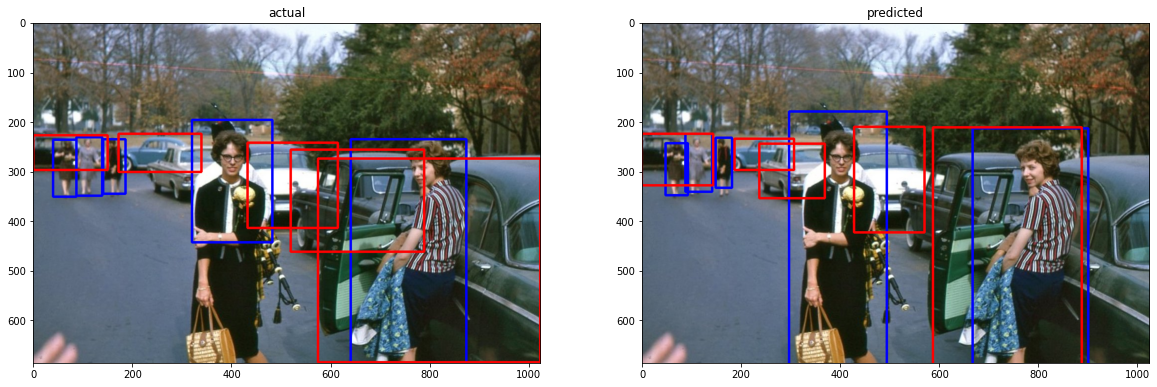

In [94]:
## show-time
fig = plt.figure(figsize=(20,20))

fig.add_subplot(1, 2, 1)
plt.title('actual')
plt.imshow(actual)

fig.add_subplot(1, 2, 2)
plt.title('predicted')
plt.imshow(predicted)

#### It took only 0.72 seconds for inference -> 1.38 FPS on core i5 cpu using python (it gets better when inference is done suign darknet)

### false Negative

inference time:  1.0437676906585693


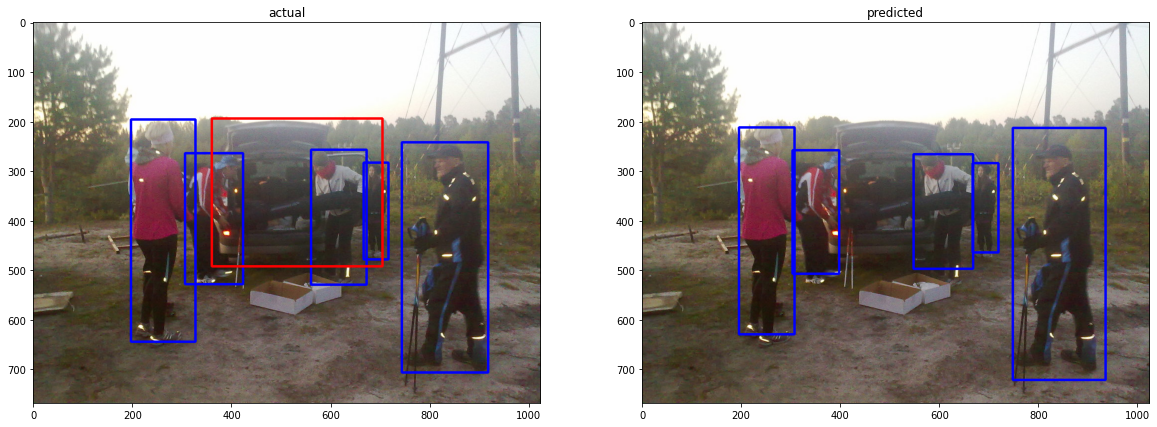

In [103]:
# selecting image
demo_path = test_imgs[-1]

img_id = images_annot[images_annot['file_name']==demo_path]['id'].iloc[0]
img_path = os.path.join( 'images', demo_path)

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
actual = img.copy()
predicted = img.copy()

## plotting bbox on actual
for index, row in annot[annot['image_id']==img_id].iterrows():
    pt1 = row['bbox'][:2]
    pt2 = np.sum([row['bbox'][:2], row['bbox'][2:]], axis=0)
    cv2.rectangle(actual, tuple(pt1), tuple(pt2), tuple(color_mapping[row['category_id']]), 3)

## predictions
start = time.time()
detections = yolo_detect(yolov4, input_filepath=[img_path], 
                               confidence_threshold=0.3, 
                               yolo_width=608, 
                               yolo_height=608, 
                               save_output=False,
                                nms_threshold= 0.3)
print('inference time: ', time.time()-start)

## plotting bbox on predicted
for cat, conf, bbox in detections[0]:
    pt1 = bbox[:2]
    pt2 = np.sum([bbox[:2], bbox[2:]], axis=0)
    cv2.rectangle(predicted, tuple(pt1), tuple(pt2), tuple(cat_color_mapping[cat]), 3)

## show-time
fig = plt.figure(figsize=(20,20))

fig.add_subplot(1, 2, 1)
plt.title('actual')
plt.imshow(actual)

fig.add_subplot(1, 2, 2)
plt.title('predicted')
plt.imshow(predicted)

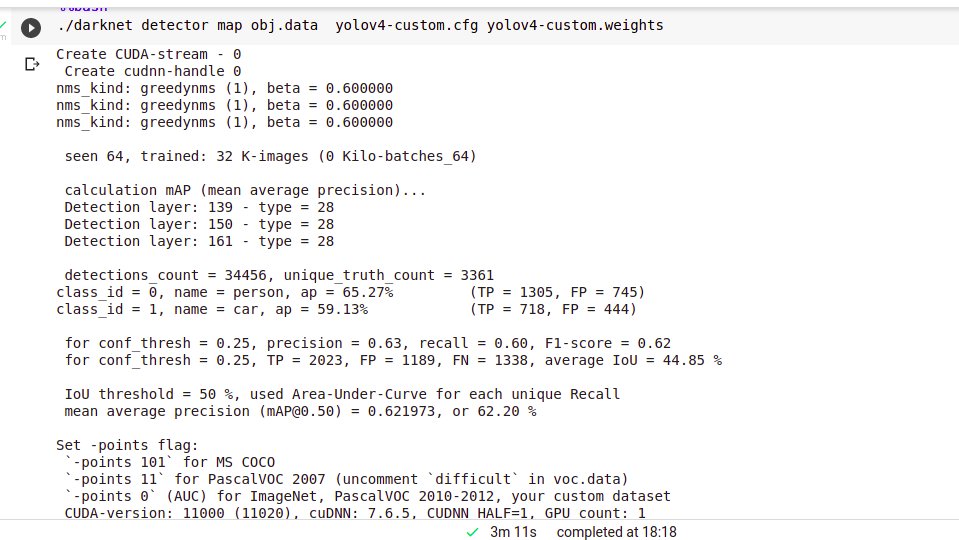

In [86]:
from IPython.display import Image
Image(filename='map.png')